# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [33]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013
5,WESTERN MISSOURI MEDICAL CENTER,260097,MO,READM-30-HIP-KNEE-HRRP,141,NaN,1.5189,8.1,5.3,19.0,07/01/2010,06/30/2013
6,SAINT AGNES HOSPITAL,210011,MD,READM-30-HIP-KNEE-HRRP,390,NaN,1.5079,7.8,5.2,38.0,07/01/2010,06/30/2013
7,MERCY HOSPITAL JEFFERSON,260023,MO,READM-30-HIP-KNEE-HRRP,178,NaN,1.5019,9.2,6.1,24.0,07/01/2010,06/30/2013
8,ONSLOW MEMORIAL HOSPITAL,340042,NC,READM-30-HIP-KNEE-HRRP,98,NaN,1.4953,7.9,5.3,15.0,07/01/2010,06/30/2013
9,FAUQUIER HOSPITAL,490023,VA,READM-30-HIP-KNEE-HRRP,256,NaN,1.4844,7.4,5.0,26.0,07/01/2010,06/30/2013


****
## Preliminary Analysis

In [39]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15625,FAIRVIEW DEVELOPMENTAL CENTER,50548,CA,READM-30-HF-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15642,WAGONER COMMUNITY HOSPITAL,370166,OK,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15648,ST LUKE'S HOSPITAL AT THE VINTAGE,670075,TX,READM-30-HIP-KNEE-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15652,SOUTH TEXAS SURGICAL HOSPITAL,670061,TX,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15396,GEORGE L MEE MEMORIAL HOSPITAL,50189,CA,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


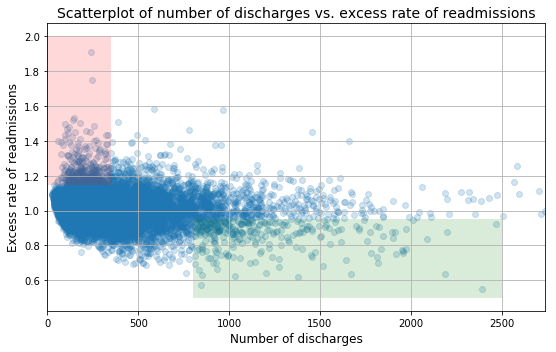

In [28]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
<div class="span5 alert alert-info">
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

In [29]:
# Your turn

In [48]:
import numpy
import math

In [71]:
small_hospitals = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] < 100]
len(small_hospitals), len(clean_hospital_read_df)

(1269, 11578)

In [86]:
def z_score(value, mean, std, sample_size):
    signal = value - mean
    noise = std / numpy.sqrt(sample_size - 1)
    return signal / noise

In [87]:
clean_readmission_ratios = clean_hospital_read_df[clean_hospital_read_df['Excess Readmission Ratio'] > 0]
clean_small_hospitals = small_hospitals[small_hospitals['Excess Readmission Ratio'] > 0]
clean_small_hospitals

small_array = numpy.array(clean_small_hospitals['Excess Readmission Ratio'])
group_array = numpy.array(clean_readmission_ratios['Excess Readmission Ratio'])

small_array.mean(), group_array.mean()
z_score(small_array.mean(), group_array.mean(), group_array.std(), len(clean_hospital_read_df))

17.684528834316602

In [ ]:
#clean_small_hospitals = small_hospitals[small_hospitals['Excess Readmission Ratio'] > 0]
#arr = numpy.array(clean_small_hospitals['Excess Readmission Ratio'])
#clean_small_hospitals
#clean_small_hospitals.columns
#arr.mean(), arr.std()